In [4]:
import sys 
import os 
#if you are going to use this code locally change the specified file pahts to fit your local file paths
sys.path.append('/Users/habibaadawi/Documents/projects/easygo/easygo_ai/models')
sys.path.append('/Users/habibaadawi/Documents/projects/easygo/easygo_ai/models/shared')
from shared.config import *
from shared.feature_engineering_v1 import *
from shared.feature_engineering_v2 import *
from shared.preprocessing import *
from shared import config, data_loader, utils 
from shared import feature_engineering_v1               

In [5]:
import seaborn as sns 
import matplotlib.pyplot as plt 

We collected data manually via gtfs API for realtime data --> https://gtfsrt.prod.obanyc.com/tripUpdates?key={api_key}

- We schedualed 5 times per day to fetch this api in a github repo .Eventually collected 7 consective days 
- this data might not be variant enough to make the model generalize better on unseen data ,so we used an external (ready to be used df for delhi city). This is a temproray solution to the real time data shortage :( 
- Since crowd data is so hard to find (unsynthatic data), we will use the same fomula used to estimate the crowd level of the delhi df.

# Delhi df

In [3]:
#Delhi data 
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adarshdubey001/delhi-bus-transit-data-enhanced-for-ml")

print("Path to dataset files:", path)

Path to dataset files: /Users/habibaadawi/.cache/kagglehub/datasets/adarshdubey001/delhi-bus-transit-data-enhanced-for-ml/versions/1


In [40]:
delhi_df = pd.read_csv('/Users/habibaadawi/Documents/projects/easygo/easygo_ai/models/data/data_for_crowd_prediciton/GTFS_Data.csv')

# NY data (the data we collected via the API of gtfs)

## Loading static dataset 


In [5]:
base_dir = '/Users/habibaadawi/Documents/projects/easygo/easygo_ai/models/data/raw/static_3/gtfs_merged'
    
# Load your data
data_dict = data_loader.load_GTF_static_data_v2(base_dir, traffic_data=False, weather_data=False)

# Assign to separate DataFrames
stops_df = data_dict['stops']
routes_df = data_dict['routes']
stop_times_df = data_dict['stop_times']
trips_df = data_dict['trips']
#taxi_df = data_dict['taxi']
#weather_df = data_dict['weather']

print("DataFrames loaded successfully!")
print(f"Stops: {stops_df.shape}")
print(f"Routes: {routes_df.shape}")
#print(f"Taxi: {taxi_df.shape}")
#print(f"Weather: {weather_df.shape}")          

DataFrames loaded successfully!
Stops: (11700, 11)
Routes: (1440, 10)


### Cleaning and feature engineering static data 

In [6]:
routes_df = clean_routes_data(routes_df)
stop_times_df = clean_stop_times_data(stop_times_df)
stops_df = clean_stops_data(stops_df)
trips_df = clean_trips_data(trips_df)

extract_routes_df = FeatureEngineeringRouteDf()
routes_df_more = extract_routes_df.feature_engineering_for_route_id(routes_df)
routes_df_more = extract_routes_df.feature_engineering_for_route_long_name(routes_df)
routes_df_more = extract_routes_df.apply_all_feature_engineering(routes_df)


stop_times_df_more = extract_stop_times_features(stop_times_df)
stops_df_more = extract_stops_features(stops_df)
trips_df_more = extract_trip_features(trips_df)

✅ Created 8 optimized features from route_id
📊 New features: ['route_id_length', 'is_single_char', 'main_route_group', 'predicted_color_family', 'route_importance_score', 'is_manhattan_core', 'is_peak_hour_only', 'estimated_route_age']
✅ Created 21 optimized features from route_long_name
📊 New features: ['main_corridor', 'boroughs_mentioned_count', 'boroughs_mentioned', 'areas_mentioned_count', 'areas_mentioned', 'service_type', 'service_pattern', 'has_time_restriction', 'is_crosstown', 'is_avenue_based', 'is_street_based', 'has_multiple_services', 'long_name_length', 'long_name_word_count', 'contains_borough_name', 'serves_manhattan_cbd', 'name_complexity', 'likely_tourist_route', 'likely_commuter_route', 'network_role', 'coverage_breadth']
🚀 Starting optimized feature engineering for routes dataframe...
✅ Created 8 optimized features from route_id
📊 New features: ['route_id_length', 'is_single_char', 'main_route_group', 'predicted_color_family', 'route_importance_score', 'is_manhatta

/Users/habibaadawi/Documents/projects/easygo/easygo_ai/models/shared/feature_engineering_v2.py:339: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
/Users/habibaadawi/Documents/projects/easygo/easygo_ai/models/shared/feature_engineering_v2.py:366: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['is_terminal_stop'] = df['stop_name_clean'].str.contains(
/Users/habibaadawi/Documents/projects/easygo/easygo_ai/models/shared/feature_engineering_v2.py:370: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['is_interchange_stop'] = df['stop_na

## Loading real time data 

In [7]:
import pandas as pd
import glob

folder_path = "/Users/habibaadawi/Documents/projects/easygo/easygo_ai/models/GTFS_data_collecter/data"

# 1. Load all CSV files
files = glob.glob(folder_path + "/*.csv")

dfs = []
for f in files:
    df = pd.read_csv(f)

    # Extract timestamp from file name
    # e.g. gtfs_data_2025-11-07_12-43.csv
    ts = f.split("gtfs_data_")[-1].replace(".csv", "")
    
    df["snapshot_timestamp"] = ts
    dfs.append(df)

# 2. Combine all
full_df = pd.concat(dfs, ignore_index=True)

# 3. Remove duplicate rows
full_df.drop_duplicates(inplace=True)

# 4. Shuffle for randomness
full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)

# 5. (Optional) Extract useful time features
full_df["snapshot_timestamp"] = pd.to_datetime(full_df["snapshot_timestamp"], 
                                               format="%Y-%m-%d_%H-%M")
full_df["hour"] = full_df["snapshot_timestamp"].dt.hour
full_df["dayofweek"] = full_df["snapshot_timestamp"].dt.dayofweek
full_df["is_weekend"] = full_df["dayofweek"].isin([5,6]).astype(int)

print(full_df.shape)
full_df.head()


(13458052, 12)


,timestamp,trip_id,route_id,stop_id,arrival_time,departure_time,arrival_delay,departure_delay,snapshot_timestamp,hour,dayofweek,is_weekend
0,2025-11-09 16:19:22.281585,OF_D5-Sunday-069000_M35_306,M35,405609,2025-11-09 16:25:41,2025-11-09 16:25:41,NaN,NaN,2025-11-09 16:23:00,16,6,1
1,2025-11-07 16:20:23.164333,44037744-CPPD5-CP_D5-Weekday-10-SDon,Q25,551050,2025-11-07 17:17:25,2025-11-07 17:17:25,NaN,NaN,2025-11-07 16:22:00,16,4,0
2,2025-11-10 12:43:38.643229,FB_D5-Weekday-SDon-044400_B44_314,B44,303479,2025-11-10 13:10:06,2025-11-10 13:10:06,NaN,NaN,2025-11-10 12:45:00,12,0,0
3,2025-11-11 04:16:08.647920,MV_D5-Weekday-SDon-138500_M3_347,M2,400335,2025-11-11 05:13:19,2025-11-11 05:13:19,NaN,NaN,2025-11-11 04:21:00,4,1,0
4,2025-11-13 04:22:45.043982,WF_D5-Weekday-SDon-144000_BX17_283,BX17,101249,2025-11-13 05:18:29,2025-11-13 05:18:29,NaN,NaN,2025-11-13 04:23:00,4,3,0


In [8]:
(full_df['arrival_time'] == full_df['departure_time']).value_counts()
# this is a common problem in real time data in gtfs .I will drop one of the columns 

True    13458052
Name: count, dtype: int64

In [9]:
full_df = full_df.drop(columns=['departure_time','arrival_delay', 'departure_delay'])

In [10]:
full_df.columns

Index(['timestamp', 'trip_id', 'route_id', 'stop_id', 'arrival_time',
       'snapshot_timestamp', 'hour', 'dayofweek', 'is_weekend'],
      dtype='object')

## Checking matches between static and real data 

In [11]:
# Trip ID match
trip_match = full_df["trip_id"].isin(stop_times_df["trip_id"])
trip_coverage = 100 * trip_match.sum() / len(full_df)

# Stop ID match
stop_match = full_df["stop_id"].isin(stop_times_df["stop_id"])
stop_coverage = 100 * stop_match.sum() / len(full_df)

route_match = full_df["route_id"].isin(routes_df["route_id"])
route_coverage = 100 * route_match.sum() / len(full_df)
print("\n=== COMPATIBILITY REPORT ===")
print(f"Trip ID match coverage: {trip_coverage:.2f}%")
print(f"Stop ID match coverage: {stop_coverage:.2f}%")
print(f"route ID match coverage: {route_coverage:.2f}%")


=== COMPATIBILITY REPORT ===
Trip ID match coverage: 84.86%
Stop ID match coverage: 88.04%
route ID match coverage: 84.86%


## Merging real and static data 

In [16]:
import duckdb 
con = duckdb()
static_merged_df = con.execute(""" 
     SELECT 
         -- From stop_times_df
         st.stop_id,
         st.stop_sequence,
         st.arrival_time,
         st.departure_time,            

         -- From trips_df (t
         t.trip_id,                      
         t.route_id,
         t.direction_id,             

         -- From stops_df (s
         s.stop_lat,
         s.stop_lon,

         -- From routes_df (r)
         r.is_express,
         r.corridor_count,
         
                        
     FROM stop_times st 
     LEFT JOIN stops s ON st.stop_id = s.stop_id
     LEFT JOIN trips t ON st.trip_id = t.trip_id
     LEFT JOIN routes r ON t.route_id = r.route_id                                  
""").df()

TypeError: 'module' object is not callable

In [ ]:

static_merged_df = static_merged_df.sort_values(by=['trip_id', 'stop_sequence'])
static_merged_df['dest_lat'] = static_merged_df.groupby('trip_id')['stop_lat'].shift(-1)
static_merged_df['dest_lon'] = static_merged_df.groupby('trip_id')['stop_lon'].shift(-1)

In [ ]:
static_merged_df.trip_id.nunique()

185050

In [ ]:
#the null values of the dest_lat and dest_lon represents the end of each trip id 
static_merged_df.isna().sum()

stop_id                0
stop_sequence          0
arrival_time           0
departure_time         0
trip_id                0
route_id               0
direction_id           0
stop_lat               0
stop_lon               0
is_express             0
corridor_count         0
dest_lat          185050
dest_lon          185050
dtype: int64

In [ ]:
# Create indicator for last stop using the missing values in dest_lat/dest_lon
# (Missing values indicate the last stop of each trip from the shift(-1) operation)
static_merged_df['is_last_stop'] = static_merged_df['dest_lat'].isna().astype(int)

# Now fill NaN values in dest_lat and dest_lon
# For the last stop, use transform to get the actual last stop coordinates for each trip
static_merged_df['dest_lat'] = static_merged_df['dest_lat'].fillna(
    static_merged_df.groupby('trip_id')['stop_lat'].transform('last')
)
static_merged_df['dest_lon'] = static_merged_df['dest_lon'].fillna(
    static_merged_df.groupby('trip_id')['stop_lon'].transform('last')
)

# Verify the changes
print(f"Missing dest_lat: {static_merged_df['dest_lat'].isna().sum()}")  # Should be 0
print(f"Missing dest_lon: {static_merged_df['dest_lon'].isna().sum()}")  # Should be 0
print(f"Number of last stops: {static_merged_df['is_last_stop'].sum()}")  # Should equal number of unique trips
print(f"Number of unique trips: {static_merged_df['trip_id'].nunique()}")

# Check a sample trip to verify
sample_trip = static_merged_df[static_merged_df['trip_id'] == static_merged_df['trip_id'].iloc[0]].sort_values('stop_sequence')


Missing dest_lat: 0
Missing dest_lon: 0
Number of last stops: 0
Number of unique trips: 185050


I made sure none of the static and real data have null values . And I made an extra column that indicates wether or this stop is the last stop or not 

In [ ]:
#i will make sure that the id columns are of type object  for both static and real df 
static_merged_df = utils.convert_id_columns_to_str(static_merged_df)
full_df = utils.convert_id_columns_to_str(full_df)

In [ ]:
static_merged_df.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 6375293 entries, 1108638 to 1513221
Data columns (total 14 columns):
 #   Column          Dtype          
---  ------          -----          
 0   stop_id         object         
 1   stop_sequence   int64          
 2   arrival_time    timedelta64[ns]
 3   departure_time  timedelta64[ns]
 4   trip_id         object         
 5   route_id        object         
 6   direction_id    object         
 7   stop_lat        float64        
 8   stop_lon        float64        
 9   is_express      int64          
 10  corridor_count  int64          
 11  dest_lat        float64        
 12  dest_lon        float64        
 13  is_last_stop    int64          
dtypes: float64(4), int64(4), object(4), timedelta64[ns](2)
memory usage: 729.6+ MB


In [ ]:
static_merged_df.columns 

Index(['stop_id', 'stop_sequence', 'arrival_time', 'departure_time', 'trip_id',
       'route_id', 'direction_id', 'stop_lat', 'stop_lon', 'is_express',
       'corridor_count', 'dest_lat', 'dest_lon'],
      dtype='object')

In [ ]:
#merging static and real time dfs
merged_df = full_df.merge(
    static_merged_df[['stop_id', 'stop_sequence', 'arrival_time', 'departure_time', 'trip_id',
       'route_id', 'direction_id', 'stop_lat', 'stop_lon', 'is_express',
       'corridor_count', 'dest_lat', 'dest_lon', 'is_last_stop']],  # Select only needed static columns
    on=['trip_id', 'route_id', 'stop_id'],
    how='inner', #to make sure there are no real data that doesn't exist in static data 
    suffixes=('_real', '_static')
)

In [ ]:
# Our final merged df in its full GLORY :> 
merged_df.isna().sum()

timestamp              0
trip_id                0
route_id               0
stop_id                0
arrival_time_real      0
snapshot_timestamp     0
hour                   0
dayofweek              0
is_weekend             0
stop_sequence          0
arrival_time_static    0
departure_time         0
direction_id           0
stop_lat               0
stop_lon               0
is_express             0
corridor_count         0
dest_lat               0
dest_lon               0
is_last_stop           0
dtype: int64

### Cleaning merged df

In [ ]:
#since the mechanism the gtfs API was used may have retruned the same trip_id with the same stop id multiple times ,so we need to remove these duplicates ,which are noise.
merged_df = merged_df.sort_values('snapshot_timestamp').groupby(
    ['trip_id', 'stop_id', 'stop_sequence'],
    as_index=False
).last()

#notice how much the data will be reduced from 13M >> 1 M 
merged_df.shape

(1128526, 20)

the following code (generated by AI :)) is used to analyze the merged_df .It checks for the following things in the merged df : 
- Sequence continuity - are there gaps (e.g., 1,2,4,5 - missing 3)?
- Starting points - do sequences start at 1 or some other number?
- Duplicates - same stop_sequence appearing twice in one trip (data quality issue)
- Distribution patterns - visualize stop sequences across the dataset
- Last stop verification - if you have is_last_stop, verify it's correct
- Route-level patterns - which routes have the most stops

STOP SEQUENCE OVERVIEW
Total rows: 1,128,526
Unique trips: 56,330
Unique stops: 11,330
Stop sequence range: 1 to 115

Stops per trip:
  Mean: 20.0
  Median: 17
  Min: 1
  Max: 115
  Std Dev: 15.9

Analyzing sequence continuity...

Trips starting at sequence 1: 29709 (52.7%)
Trips with gaps in sequence: 6771 (12.0%)

⚠️ Sample trips with sequence gaps:
  Trip CA_D5-Saturday-043000_MISC_260: 19 stops, sequences 16-37, gaps: [(np.int64(20), np.int64(24), np.int64(3))]
  Trip CA_D5-Saturday-043000_MISC_262: 17 stops, sequences 16-34, gaps: [(np.int64(18), np.int64(21), np.int64(2))]
  Trip CA_D5-Saturday-044000_MISC_245: 28 stops, sequences 8-37, gaps: [(np.int64(17), np.int64(20), np.int64(2))]
  Trip CA_D5-Saturday-045000_MISC_247: 35 stops, sequences 3-39, gaps: [(np.int64(17), np.int64(20), np.int64(2))]
  Trip CA_D5-Saturday-045000_MISC_264: 31 stops, sequences 4-37, gaps: [(np.int64(20), np.int64(24), np.int64(3))]

SAMPLE TRIP DETAILS (First 3 trips)

Trip ID: CA_D5-Saturday-017000_

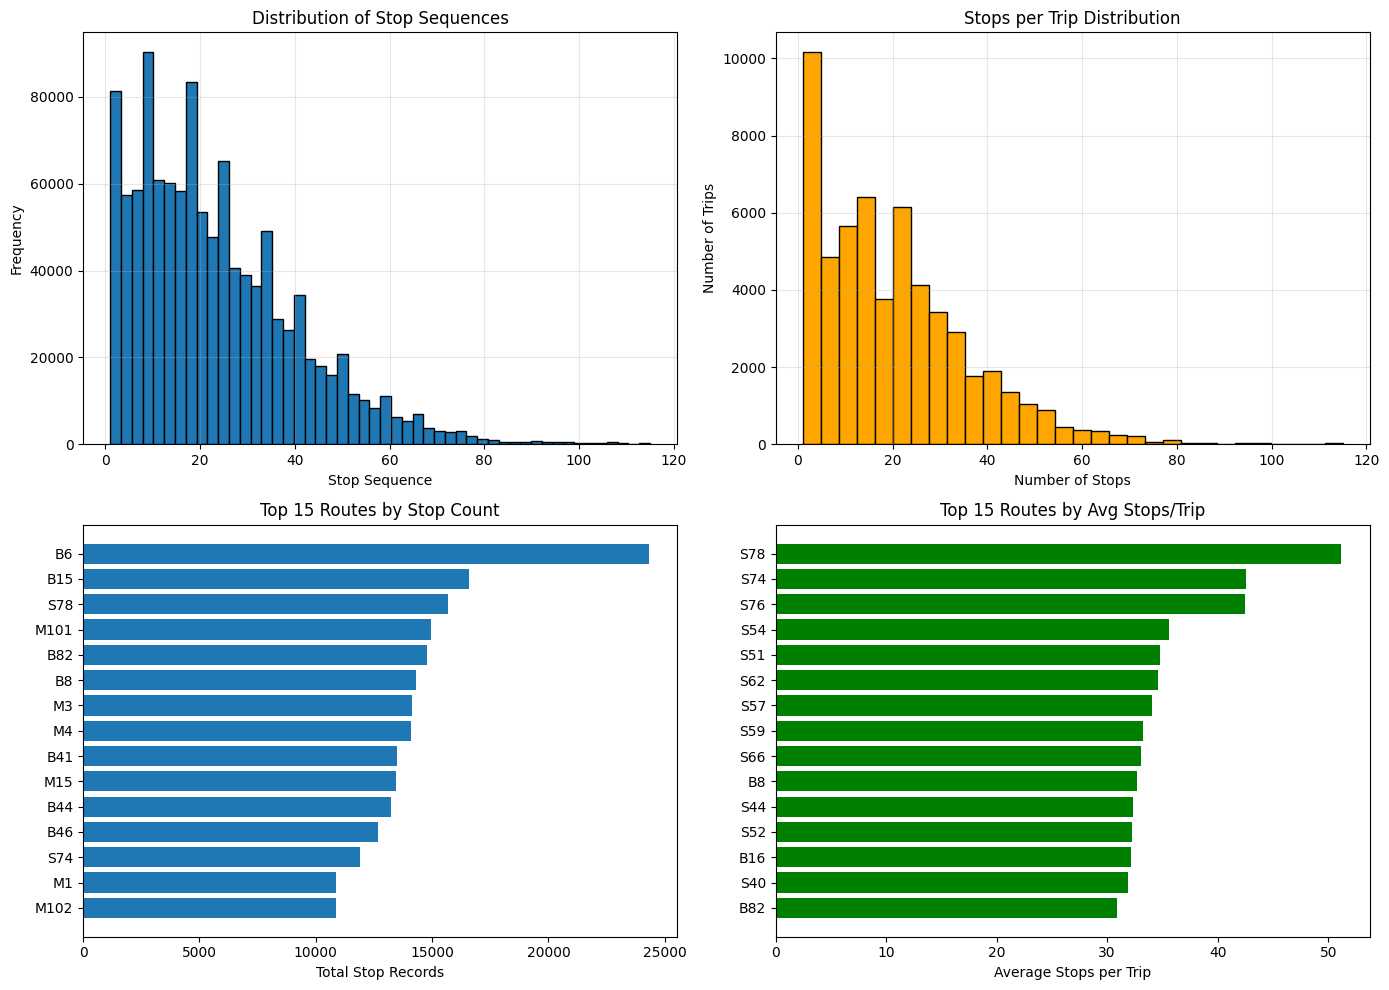


LAST STOP VERIFICATION
is_last_stop alignment with max sequence: 95.01%
⚠️ Found 56330 misaligned last stop indicators
                           trip_id  stop_sequence  is_last_stop
0    CA_D5-Saturday-017000_S53_100             44             0
5   CA_D5-Saturday-018000_MISC_222             48             0
6   CA_D5-Saturday-018000_MISC_224             45             0
19  CA_D5-Saturday-018000_S4696_45             51             0
56  CA_D5-Saturday-019500_S4696_48             51             0

SUMMARY REPORT
✓ Dataset has 1,128,526 records across 56,330 trips
✓ Stop sequences range from 1 to 115
✓ Average 20.0 stops per trip
⚠️ High rate of sequence gaps (12.0% of trips)
✓ No duplicate stop sequences within trips

✅ Analysis complete!


In [ ]:
# ============================================================================
# STOP SEQUENCE ANALYSIS FOR YOUR MERGED DATAFRAME
# ============================================================================

# 1. Basic Stop Sequence Statistics
print("="*80)
print("STOP SEQUENCE OVERVIEW")
print("="*80)
print(f"Total rows: {len(merged_df):,}")
print(f"Unique trips: {merged_df['trip_id'].nunique():,}")
print(f"Unique stops: {merged_df['stop_id'].nunique():,}")
print(f"Stop sequence range: {merged_df['stop_sequence'].min()} to {merged_df['stop_sequence'].max()}")

# 2. Stops per Trip Distribution
stops_per_trip = merged_df.groupby('trip_id').size()
print(f"\nStops per trip:")
print(f"  Mean: {stops_per_trip.mean():.1f}")
print(f"  Median: {stops_per_trip.median():.0f}")
print(f"  Min: {stops_per_trip.min()}")
print(f"  Max: {stops_per_trip.max()}")
print(f"  Std Dev: {stops_per_trip.std():.1f}")

# 3. Check Stop Sequence Continuity Within Trips
def check_sequence_gaps(df):
    """Check if stop sequences have gaps within each trip"""
    results = []
    
    for trip_id, group in df.groupby('trip_id'):
        sequences = sorted(group['stop_sequence'].unique())
        
        # Check for gaps
        has_gaps = False
        gaps = []
        for i in range(len(sequences)-1):
            gap = sequences[i+1] - sequences[i]
            if gap > 1:
                has_gaps = True
                gaps.append((sequences[i], sequences[i+1], gap-1))
        
        # Check if starts from 1
        starts_at_one = sequences[0] == 1
        
        results.append({
            'trip_id': trip_id,
            'num_stops': len(sequences),
            'min_seq': sequences[0],
            'max_seq': sequences[-1],
            'starts_at_one': starts_at_one,
            'has_gaps': has_gaps,
            'gaps': gaps
        })
    
    return pd.DataFrame(results)

print("\nAnalyzing sequence continuity...")
sequence_analysis = check_sequence_gaps(merged_df)

print(f"\nTrips starting at sequence 1: {sequence_analysis['starts_at_one'].sum()} ({sequence_analysis['starts_at_one'].mean()*100:.1f}%)")
print(f"Trips with gaps in sequence: {sequence_analysis['has_gaps'].sum()} ({sequence_analysis['has_gaps'].mean()*100:.1f}%)")

# Show examples of trips with gaps
if sequence_analysis['has_gaps'].any():
    print("\n⚠️ Sample trips with sequence gaps:")
    trips_with_gaps = sequence_analysis[sequence_analysis['has_gaps']].head(5)
    for _, row in trips_with_gaps.iterrows():
        print(f"  Trip {row['trip_id']}: {row['num_stops']} stops, sequences {row['min_seq']}-{row['max_seq']}, gaps: {row['gaps']}")

# 4. Detailed View of Sample Trips
print("\n" + "="*80)
print("SAMPLE TRIP DETAILS (First 3 trips)")
print("="*80)

sample_trips = merged_df['trip_id'].unique()[:3]
for trip_id in sample_trips:
    trip_data = merged_df[merged_df['trip_id'] == trip_id].sort_values('stop_sequence')
    
    print(f"\nTrip ID: {trip_id}")
    print(f"Route: {trip_data['route_id'].iloc[0]}, Direction: {trip_data['direction_id'].iloc[0]}")
    print(f"Total stops: {len(trip_data)}")
    print(f"Time range: {trip_data['timestamp'].min()} to {trip_data['timestamp'].max()}")
    print("\nStop sequence:")
    print(trip_data[['stop_sequence', 'stop_id', 'stop_lat', 'stop_lon', 
                     'arrival_time_static', 'arrival_time_real']].to_string(index=False, max_rows=10))
    
    if len(trip_data) > 10:
        print(f"... ({len(trip_data) - 10} more stops)")

# 5. Check for Duplicate Stop Sequences Within Trips
print("\n" + "="*80)
print("CHECKING FOR DUPLICATE SEQUENCES")
print("="*80)

duplicates = merged_df.groupby(['trip_id', 'stop_sequence']).size()
duplicates = duplicates[duplicates > 1]

if len(duplicates) > 0:
    print(f"⚠️ Found {len(duplicates)} trip-stop_sequence combinations with duplicates!")
    print("\nSample duplicates:")
    print(duplicates.head(10))
    
    # Show details of one duplicate
    sample_dup = duplicates.index[0]
    dup_data = merged_df[(merged_df['trip_id'] == sample_dup[0]) & 
                          (merged_df['stop_sequence'] == sample_dup[1])]
    print(f"\nExample: Trip {sample_dup[0]}, Sequence {sample_dup[1]}:")
    print(dup_data[['timestamp', 'stop_id', 'stop_sequence', 'arrival_time_real']])
else:
    print("✅ No duplicate stop sequences within trips - data looks clean!")

# 6. Visualize Stop Sequence Distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Stop sequence histogram
axes[0, 0].hist(merged_df['stop_sequence'], bins=50, edgecolor='black')
axes[0, 0].set_xlabel('Stop Sequence')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Stop Sequences')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Stops per trip histogram
axes[0, 1].hist(stops_per_trip, bins=30, edgecolor='black', color='orange')
axes[0, 1].set_xlabel('Number of Stops')
axes[0, 1].set_ylabel('Number of Trips')
axes[0, 1].set_title('Stops per Trip Distribution')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Stops by route
stops_by_route = merged_df.groupby('route_id').size().sort_values(ascending=False).head(15)
axes[1, 0].barh(range(len(stops_by_route)), stops_by_route.values)
axes[1, 0].set_yticks(range(len(stops_by_route)))
axes[1, 0].set_yticklabels(stops_by_route.index)
axes[1, 0].set_xlabel('Total Stop Records')
axes[1, 0].set_title('Top 15 Routes by Stop Count')
axes[1, 0].invert_yaxis()

# Plot 4: Average stops per trip by route
avg_stops_by_route = merged_df.groupby(['route_id', 'trip_id']).size().groupby('route_id').mean().sort_values(ascending=False).head(15)
axes[1, 1].barh(range(len(avg_stops_by_route)), avg_stops_by_route.values, color='green')
axes[1, 1].set_yticks(range(len(avg_stops_by_route)))
axes[1, 1].set_yticklabels(avg_stops_by_route.index)
axes[1, 1].set_xlabel('Average Stops per Trip')
axes[1, 1].set_title('Top 15 Routes by Avg Stops/Trip')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

# 7. Check Last Stop Indicator Alignment
print("\n" + "="*80)
print("LAST STOP VERIFICATION")
print("="*80)

if 'is_last_stop' in merged_df.columns:
    # Verify is_last_stop matches actual last sequences
    max_seq_per_trip = merged_df.groupby('trip_id')['stop_sequence'].transform('max')
    actual_last_stops = (merged_df['stop_sequence'] == max_seq_per_trip)
    
    alignment = (merged_df['is_last_stop'] == actual_last_stops.astype(int)).mean()
    print(f"is_last_stop alignment with max sequence: {alignment*100:.2f}%")
    
    if alignment < 1.0:
        misaligned = merged_df[merged_df['is_last_stop'] != actual_last_stops.astype(int)]
        print(f"⚠️ Found {len(misaligned)} misaligned last stop indicators")
        print(misaligned[['trip_id', 'stop_sequence', 'is_last_stop']].head())
else:
    print("Note: 'is_last_stop' column not found in merged data")

# 8. Summary Report
print("\n" + "="*80)
print("SUMMARY REPORT")
print("="*80)
print(f"✓ Dataset has {len(merged_df):,} records across {merged_df['trip_id'].nunique():,} trips")
print(f"✓ Stop sequences range from {merged_df['stop_sequence'].min()} to {merged_df['stop_sequence'].max()}")
print(f"✓ Average {stops_per_trip.mean():.1f} stops per trip")

if sequence_analysis['has_gaps'].mean() < 0.1:
    print(f"✓ Sequence continuity is good ({sequence_analysis['has_gaps'].mean()*100:.1f}% have gaps)")
else:
    print(f"⚠️ High rate of sequence gaps ({sequence_analysis['has_gaps'].mean()*100:.1f}% of trips)")

if len(duplicates) == 0:
    print("✓ No duplicate stop sequences within trips")
else:
    print(f"⚠️ {len(duplicates)} duplicate stop sequences found")

print("\n✅ Analysis complete!")

The data actually looks clean ,but there are some key points that can be a problem later on --> 
- there is a 12% sequence gap --> this can later on be removed or left (I will decide in modeling)
- there are some incomplete trips as well (the data was collecting the trip info mid trip not from the beginning of the trip)(I will decide removing them or leaving them in modeling)

In [ ]:
#one more thing to consider is dropping the is_last_stop column ,since some of the trip's stop sequences in static data doesn't match the real time stop sequences .
merged_df = merged_df.drop(columns=['is_last_stop'])

In [ ]:
# I will save the cleaned merged df in a spearate csv file 
merged_df.to_csv('/Users/habibaadawi/Documents/projects/easygo/easygo_ai/models/GTFS_data_collecter/merged_clean_df')

In [17]:
import requests
import pandas as pd
from tqdm import tqdm
import time

def add_weather_traffic_features_safe(df, weather_api_key, traffic_api_key, save_every=5000, save_path="progress.csv"):
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
    # Initialize columns
    new_cols = [
        'temperature', 'humidity', 'wind_speed', 'weather_condition',
        'current_travel_time', 'free_flow_travel_time', 'congestion_level'
    ]
    for col in new_cols:
        if col not in df.columns:
            df[col] = None

    cache = {}
    last_save = time.time()

    for i, row in tqdm(df.iterrows(), total=len(df), desc="Fetching weather & traffic"):
        lat, lon = row['stop_lat'], row['stop_lon']
        key = (round(lat, 3), round(lon, 3))

        # Skip already processed rows
        if pd.notnull(df.at[i, 'temperature']):
            continue  

        # Fetch from cache or API
        if key in cache:
            data = cache[key]
        else:
            data = {}
            try:
                w = requests.get(
                    f"https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}"
                    f"&appid={weather_api_key}&units=metric"
                ).json()
                data.update({
                    "temperature": w.get("main", {}).get("temp"),
                    "humidity": w.get("main", {}).get("humidity"),
                    "wind_speed": w.get("wind", {}).get("speed"),
                    "weather_condition": w.get("weather", [{}])[0].get("main")
                })
            except Exception as e:
                print(f"⚠️ Weather fetch failed at row {i}: {e}")
                data.update({col: None for col in new_cols})

            try:
                t = requests.get(
                    f"https://api.tomtom.com/traffic/services/4/flowSegmentData/absolute/10/json?"
                    f"point={lat},{lon}&key={traffic_api_key}"
                ).json()
                flow = t.get("flowSegmentData", {})
                data.update({
                    "current_travel_time": flow.get("currentTravelTime"),
                    "free_flow_travel_time": flow.get("freeFlowTravelTime"),
                    "congestion_level": (
                        round(flow["currentTravelTime"]/flow["freeFlowTravelTime"], 2)
                        if flow.get("freeFlowTravelTime") else None
                    )
                })
            except Exception as e:
                print(f"⚠️ Traffic fetch failed at row {i}: {e}")

            cache[key] = data

        # Update DataFrame
        for col in data:
            df.at[i, col] = data[col]

        # ✅ Print fetched result
        print(f"Row {i} | Lat: {lat}, Lon: {lon} → {data}")

        # Auto-save every N rows or every 60 seconds
        if (i+1) % save_every == 0 or (time.time() - last_save > 60):
            df.to_csv(save_path, index=False)
            print(f"💾 Progress saved to {save_path} at row {i+1}")
            last_save = time.time()

    # Final save
    df.to_csv(save_path, index=False)
    print("✅ Final save complete.")
    return df


## Adding speed, distance, crowd column  

In [8]:

def add_travel_features(df):
    """
    Takes a DataFrame and adds travel time, distance, and speed features between consecutive stops.
    Original dataframe is preserved; a copy is used.

    Parameters:
    df (pd.DataFrame): DataFrame with at least the following columns:
        ['trip_id', 'stop_id', 'stop_sequence', 'arrival_time_real', 'stop_lat', 'stop_lon', 'timestamp']

    Returns:
    pd.DataFrame: A copy of the original dataframe with new columns added:
        'travel_time_sec', 'distance_km', 'speed_kmh'
    """

    # Make a copy to avoid modifying the original dataframe
    df_copy = df.copy()

    # Step 1: Convert timestamps
    df_copy['arrival_time_real'] = pd.to_datetime(df_copy['arrival_time_real'])
    df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])
    # Do NOT convert 'departure_time' if it's already timedelta

    # Step 2: Sort by trip and stop sequence
    df_copy = df_copy.sort_values(by=['trip_id', 'stop_sequence'])

    # Step 3: Calculate travel time (seconds) between consecutive stops
    df_copy['prev_arrival'] = df_copy.groupby('trip_id')['arrival_time_real'].shift(1)
    df_copy['travel_time_sec'] = (df_copy['arrival_time_real'] - df_copy['prev_arrival']).dt.total_seconds()

    # Step 4: Calculate distance between consecutive stops using Haversine formula
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371  # Earth radius in km
        phi1, phi2 = np.radians(lat1), np.radians(lat2)
        delta_phi = np.radians(lat2 - lat1)
        delta_lambda = np.radians(lon2 - lon1)

        a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        return R * c

    df_copy['prev_lat'] = df_copy.groupby('trip_id')['stop_lat'].shift(1)
    df_copy['prev_lon'] = df_copy.groupby('trip_id')['stop_lon'].shift(1)

    df_copy['distance_km'] = haversine(
        df_copy['prev_lat'], df_copy['prev_lon'],
        df_copy['stop_lat'], df_copy['stop_lon']
    )

    # Step 5: Calculate speed (km/h)
    df_copy['speed_kmh'] = df_copy['distance_km'] / (df_copy['travel_time_sec'] / 3600)

    # Step 6: Drop helper columns and remove rows with NaNs
    df_copy = df_copy.drop(columns=['prev_arrival', 'prev_lat', 'prev_lon'])
    df_copy = df_copy.dropna(subset=['travel_time_sec', 'distance_km', 'speed_kmh'])

    return df_copy


merged_df = add_travel_features(merged_df)



In [ ]:
merged_df.head()

,trip_id,stop_id,stop_sequence,timestamp,route_id,arrival_time_real,snapshot_timestamp,hour,dayofweek,is_weekend,...,stop_lon,is_express,corridor_count,dest_lat,dest_lon,lat_round,lon_round,travel_time_sec,distance_km,speed_kmh
2,CA_D5-Saturday-018000_MISC_222,203061,45,2025-11-08 08:27:16.001033,S40,2025-11-08 08:27:01,2025-11-08 08:31:00,8,5,1,...,-74.180,0,1,40.628713,-74.182687,40.628,40.628,71.0,0.476982,24.184998
1,CA_D5-Saturday-018000_MISC_222,200001,46,2025-11-08 08:27:16.001033,S40,2025-11-08 08:27:20,2025-11-08 08:31:00,8,5,1,...,-74.183,0,1,40.615291,-74.186935,40.629,40.629,19.0,0.276516,52.392489
4,CA_D5-Saturday-018000_MISC_222,204060,47,2025-11-08 08:29:16.657427,S40,2025-11-08 08:32:57,2025-11-08 08:31:00,8,5,1,...,-74.187,0,1,40.618936,-74.185156,40.615,40.615,337.0,1.592915,17.016299
5,CA_D5-Saturday-018000_MISC_222,805202,48,2025-11-08 08:27:16.001033,S40,2025-11-08 08:34:10,2025-11-08 08:31:00,8,5,1,...,-74.185,0,1,40.618936,-74.185156,40.619,40.619,73.0,0.475738,23.461031
8,CA_D5-Saturday-018000_S4696_45,200334,40,2025-11-08 08:26:15.660833,S46,2025-11-08 08:26:54,2025-11-08 08:31:00,8,5,1,...,-74.162,0,1,40.632202,-74.165083,40.632,40.632,47.0,0.337547,25.854645


# EDA for Delhi df 

In [ ]:
delhi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66913 entries, 0 to 66912
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   stop_id_from          66913 non-null  int64  
 1   stop_id_to            66913 non-null  int64  
 2   trip_id               66913 non-null  object 
 3   arrival_time          66644 non-null  object 
 4   time                  66913 non-null  float64
 5   speed                 66655 non-null  float64
 6   Number_of_trips       66912 non-null  float64
 7   SRI                   66600 non-null  object 
 8   Degree_of_congestion  66913 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 4.6+ MB


### Distribution of categorical values

<function matplotlib.pyplot.show(close=None, block=None)>

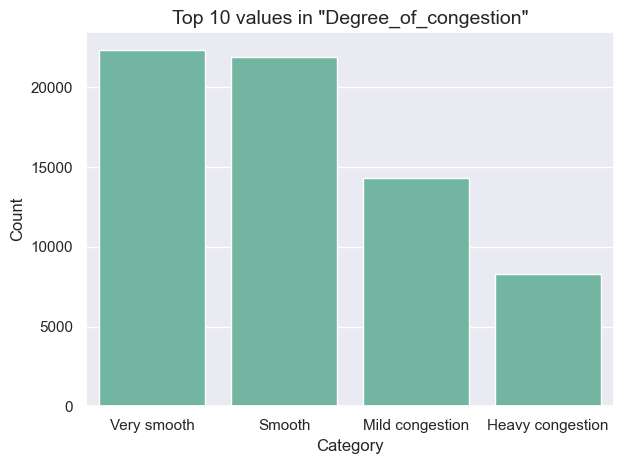

In [ ]:
sns.set_style(style="darkgrid")

col = 'Degree_of_congestion'
freq = delhi_df[col].value_counts()
ax = sns.barplot(x=freq.index, y=freq.values, orient='v')
ax.set_title(f'Top 10 values in "{col}"', fontsize=14)
ax.set_xlabel("Category")
ax.set_ylabel("Count")

plt.tight_layout()
plt.show


In [ ]:
df.groupby('Degree_of_congestion')['speed'].apply(np.mean)
# speed is normally increasing when congestion decreases :> (NORMAL)

Degree_of_congestion
Heavy congestion    20.518028
Mild congestion     30.156984
Smooth              35.869815
Very smooth         61.792552
Name: speed, dtype: float64

In [ ]:
df.groupby('Degree_of_congestion')['time'].apply(np.mean)
#(NORMAL) :> 

Degree_of_congestion
Heavy congestion    0.236050
Mild congestion     0.022450
Smooth              0.017467
Very smooth         0.012923
Name: time, dtype: float64

In [ ]:
df.groupby('Degree_of_congestion')['Number_of_trips'].apply(np.mean)
#NORMAL :> 

Degree_of_congestion
Heavy congestion    20.940354
Mild congestion     19.936850
Smooth              16.286958
Very smooth         13.054106
Name: Number_of_trips, dtype: float64

### Time and data analysis 

In [ ]:
df['hour'].value_counts()

hour
14.0    39191
9.0     14338
18.0    13115
Name: count, dtype: int64

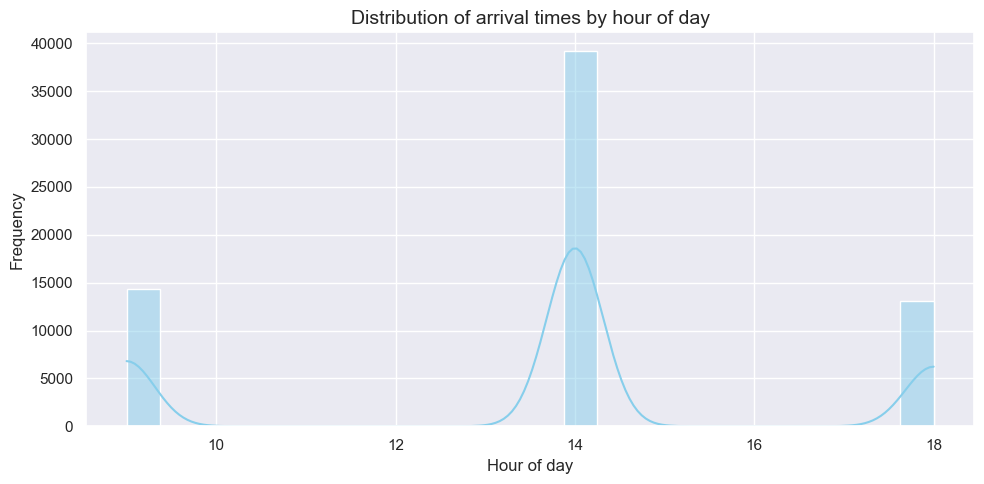

In [ ]:
df['hour'] = df['arrival_time'].dt.hour 
df['day_of_week'] = df['arrival_time'].dt.day_name()

plt.figure(figsize=(10,5))
sns.histplot(df['hour'], bins=24 , kde=True, color='skyblue')
plt.title('Distribution of arrival times by hour of day', fontsize=14)
plt.xlabel("Hour of day")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

we will eventually merge the delhi and NY dfs into one df to train the model 

# Merging Delhi and NY data 

In [6]:
merged_df = pd.read_csv('/Users/habibaadawi/Documents/projects/easygo/easygo_ai/models/GTFS_data_collecter/merged_clean_df')

In [26]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1022707 entries, 1 to 1128515
Data columns (total 23 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Unnamed: 0           1022707 non-null  int64         
 1   trip_id              1022707 non-null  object        
 2   stop_id              1022707 non-null  int64         
 3   stop_sequence        1022707 non-null  int64         
 4   timestamp            1022707 non-null  datetime64[ns]
 5   route_id             1022707 non-null  object        
 6   arrival_time_real    1022707 non-null  datetime64[ns]
 7   snapshot_timestamp   1022707 non-null  object        
 8   hour                 1022707 non-null  int64         
 9   dayofweek            1022707 non-null  int64         
 10  is_weekend           1022707 non-null  int64         
 11  arrival_time_static  1022707 non-null  object        
 12  departure_time       1022707 non-null  object        
 13  di

In [22]:
delhi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66913 entries, 0 to 66912
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   stop_id_from          66913 non-null  int64  
 1   stop_id_to            66913 non-null  int64  
 2   trip_id               66913 non-null  object 
 3   arrival_time          66644 non-null  object 
 4   time                  66913 non-null  float64
 5   speed                 66655 non-null  float64
 6   Number_of_trips       66912 non-null  float64
 7   SRI                   66600 non-null  object 
 8   Degree_of_congestion  66913 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 4.6+ MB


In [7]:
def compute_crowd(df):
    df = df.copy()

    # Ensure timestamps are datetime
    df['arrival_time_real'] = pd.to_datetime(df['arrival_time_real'])

    # Sort properly
    df = df.sort_values(['route_id', 'stop_id', 'arrival_time_real'])

    # Compute actual headway per route-stop
    df['actual_headway_sec'] = df.groupby(['route_id', 'stop_id'])['arrival_time_real']\
                                 .diff().dt.total_seconds()

    # Replace NaN for first bus of the day
    df['actual_headway_sec'] = df['actual_headway_sec'].fillna(df['actual_headway_sec'].median())

    # Compute "scheduled" headway as rolling median based on historical behavior
    df['scheduled_headway_sec'] = df.groupby(['route_id', 'stop_id'])['actual_headway_sec']\
                                    .transform(lambda x: x.rolling(20, min_periods=5).median())

    # Fill any NaNs with global median
    df['scheduled_headway_sec'] = df['scheduled_headway_sec']\
                                  .fillna(df['scheduled_headway_sec'].median())

    # Compute congestion score
    df['crowd_score'] = df['actual_headway_sec'] / df['scheduled_headway_sec']

    # Convert to categorical crowding classes
    df['crowd'] = pd.cut(
        df['crowd_score'],
        bins=[-np.inf, 0.7, 1.4, np.inf],
        labels=[0, 1, 2]  # 0=low, 1=med, 2=high
    ).astype(int)

    return df


In [9]:
merged_df = compute_crowd(merged_df)

<Axes: xlabel='crowd', ylabel='Count'>

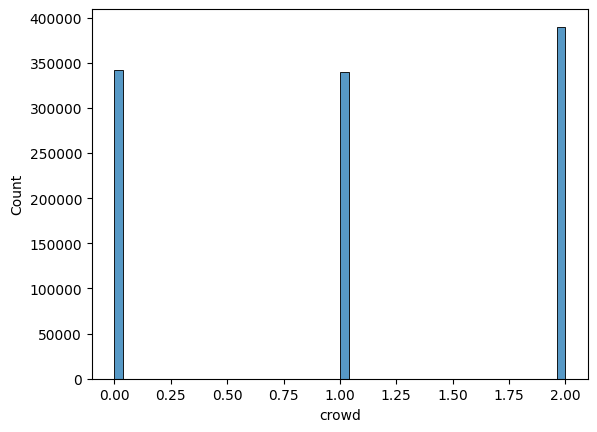

In [10]:
import seaborn as sns 
sns.histplot(merged_df['crowd'])

# Modleing 

In [12]:
#drop columns id columns 
drop_cols = []
for col in merged_df.columns: 
    if col.endswith('_id'):
        drop_cols.append(col)

merged_df = merged_df.drop(columns= drop_cols)
merged_df = merged_df.drop(columns= 'Unnamed: 0')
merged_df = merged_df.drop(columns= 'snapshot_timestamp')
merged_df = merged_df.drop(columns= 'timestamp')
merged_df = merged_df.drop(columns= 'travel_time_sec')

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt 

<function matplotlib.pyplot.show(close=None, block=None)>

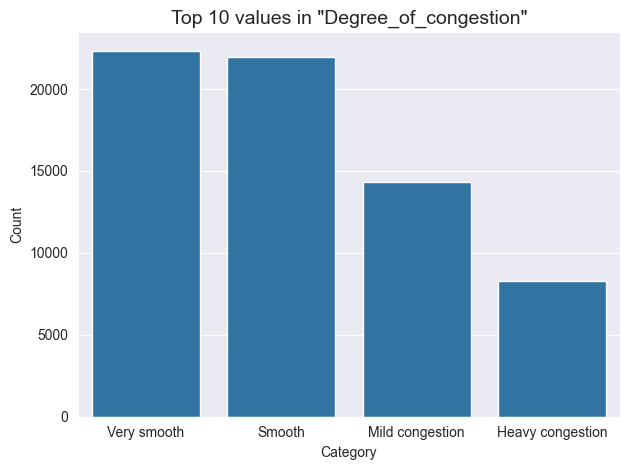

In [11]:
sns.set_style(style="darkgrid")

col = 'Degree_of_congestion'
freq = merged_df[col].value_counts()
ax = sns.barplot(x=freq.index, y=freq.values, orient='v')
ax.set_title(f'Top 10 values in "{col}"', fontsize=14)
ax.set_xlabel("Category")
ax.set_ylabel("Count")

plt.tight_layout()
plt.show


In [26]:
# I will save the cleaned merged df in a spearate csv file 
merged_df.to_csv('/Users/habibaadawi/Documents/projects/easygo/easygo_ai/models/GTFS_data_collecter/merged_clean_df')

In [4]:
merged_df = pd.read_csv('/Users/habibaadawi/Documents/projects/easygo/easygo_ai/models/GTFS_data_collecter/merged_clean_df')

In [5]:
merged_df

,stop_id_from,stop_id_to,trip_id,arrival_time,time,speed,Number_of_trips,SRI,Degree_of_congestion
0,36156,38709,NORMAL_333_Pune Station To Hinjawadi Maan Pha...,09:13:54,0.027222,14.479565,9.0,-0.40816322,Very smooth
1,36156,38709,NORMAL_115P_Pune Station to Hinjawadi Phase 3_...,09:03:01,0.032222,12.232736,9.0,1.2068965,Smooth
2,36156,38709,NORMAL_100_Ma Na Pa to Hinjawadi Maan Phase 3_...,09:15:00,0.058333,6.757130,9.0,5.142857,Heavy congestion
3,36156,38709,NORMAL_VJR5_Ma Na Pa To Mukai Chowk_Up-0905_0,09:05:00,0.033611,11.727251,9.0,1.570248,Smooth
4,36156,38709,NORMAL_100_Ma Na Pa to Hinjawadi Maan Phase 3_...,09:00:00,0.058333,6.757130,9.0,5.142857,Heavy congestion
...,...,...,...,...,...,...,...,...,...
66908,1319,1104,NORMAL_VJR6_Bhosari To Hinjawadi Maan Phase 3_...,18:01:44,0.015278,24.892663,1.0,2.1818185,Smooth
66909,1104,1106,NORMAL_VJR6_Bhosari To Hinjawadi Maan Phase 3_...,18:02:53,0.013056,37.426898,1.0,2.9787233,Mild congestion
66910,1106,1108,NORMAL_VJR6_Bhosari To Hinjawadi Maan Phase 3_...,18:03:50,0.036111,12.837577,1.0,7.076923,Heavy congestion
66911,39593,39385,NORMAL_VJR6_Hinjawadi Maan Phase 3 To Bhosari_...,18:06:00,0.003611,71.066206,1.0,-20.89835036,Very smooth


In [6]:
merged_df.columns

Index(['stop_id_from', 'stop_id_to', 'trip_id', 'arrival_time', 'time',
       'speed', 'Number_of_trips', 'SRI', 'Degree_of_congestion'],
      dtype='object')

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix)
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================
SAMPLE_SIZE = 100000  # Adjust based on your memory constraints
RANDOM_STATE = 42
TEST_SIZE = 0.2
TARGET_COLUMN = 'Degree_of_congestion'

# ============================================================================
# LOAD AND SAMPLE DATA
# ============================================================================
print("Loading data...")
# Replace 'your_data.csv' with your actual file path
df = merged_df 

print(f"Original dataset shape: {df.shape}")
print(f"\nTarget variable distribution:\n{df[TARGET_COLUMN].value_counts()}")

# Shuffle and sample the data
print(f"\nSampling {SAMPLE_SIZE} rows from {len(df)} total rows...")
df_sampled = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=RANDOM_STATE)
print(f"Sampled dataset shape: {df_sampled.shape}")

# ============================================================================
# PREPROCESSING
# ============================================================================
# Separate features and target
X = df_sampled.drop(TARGET_COLUMN, axis=1)
y = df_sampled[TARGET_COLUMN]

print("\n" + "="*70)
print("DATA CLEANING AND PREPROCESSING")
print("="*70)

# Step 1: Drop ID columns and high cardinality columns
print("\n1. Identifying and dropping ID/high cardinality columns...")
high_card_threshold = 0.95  # If unique values > 95% of rows, likely an ID
cols_to_drop = []

for col in X.columns:
    unique_ratio = X[col].nunique() / len(X)
    
    # Check if column name suggests it's an ID
    if any(id_term in col.lower() for id_term in ['id', '_id', 'uuid', 'key']):
        cols_to_drop.append(col)
        print(f"  - Dropping '{col}' (ID column)")
    
    # Check for high cardinality
    elif unique_ratio > high_card_threshold:
        cols_to_drop.append(col)
        print(f"  - Dropping '{col}' (high cardinality: {unique_ratio:.2%} unique)")

if cols_to_drop:
    X = X.drop(columns=cols_to_drop)
    print(f"\n  ✓ Dropped {len(cols_to_drop)} columns")
else:
    print("  ✓ No ID or high cardinality columns found")

# Step 2: Identify and drop columns with infinity or extreme values
print("\n2. Identifying columns with infinity or extreme values...")
numeric_cols = X.select_dtypes(include=[np.number]).columns
inf_cols_to_drop = []

for col in numeric_cols:
    # Check for infinity
    if np.isinf(X[col]).any():
        inf_count = np.isinf(X[col]).sum()
        inf_pct = (inf_count / len(X)) * 100
        inf_cols_to_drop.append(col)
        print(f"  - Dropping '{col}' ({inf_count} infinity values, {inf_pct:.2f}%)")
    
    # Check for extremely large values (beyond float32 range)
    elif X[col].abs().max() > 1e30:
        max_val = X[col].abs().max()
        inf_cols_to_drop.append(col)
        print(f"  - Dropping '{col}' (extreme value: {max_val:.2e})")

if inf_cols_to_drop:
    X = X.drop(columns=inf_cols_to_drop)
    print(f"\n  ✓ Dropped {len(inf_cols_to_drop)} columns with problematic values")
else:
    print("  ✓ No columns with infinity or extreme values found")

# Step 3: Handle categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
max_categories = 50  # Maximum unique values for one-hot encoding

if len(categorical_cols) > 0:
    print(f"\n3. Processing {len(categorical_cols)} categorical columns...")
    
    high_card_cats = []
    low_card_cats = []
    
    for col in categorical_cols:
        n_unique = X[col].nunique()
        unique_ratio = n_unique / len(X)
        
        # Drop if too many unique values or high cardinality ratio
        if n_unique > max_categories or unique_ratio > 0.5:
            high_card_cats.append(col)
            print(f"  - Dropping '{col}' (high cardinality: {n_unique} unique values, {unique_ratio:.2%})")
        else:
            low_card_cats.append(col)
            print(f"  - Encoding '{col}' ({n_unique} unique values)")
    
    # Drop high cardinality categorical columns
    if high_card_cats:
        X = X.drop(columns=high_card_cats)
        print(f"\n  ✓ Dropped {len(high_card_cats)} high cardinality categorical columns")
    
    # One-hot encode low cardinality categorical columns
    if low_card_cats:
        X = pd.get_dummies(X, columns=low_card_cats, drop_first=True)
        print(f"  ✓ One-hot encoded {len(low_card_cats)} categorical columns")
else:
    print("\n3. No categorical columns to encode")

# Step 4: Handle remaining missing values
missing_count = X.isnull().sum().sum()
if missing_count > 0:
    print(f"\n4. Handling {missing_count} missing values...")
    X = X.fillna(X.median())
    print("  ✓ Filled missing values with column medians")
else:
    print("\n4. No missing values found")

# Step 5: Final validation
print("\n5. Final data validation...")
assert not X.isnull().any().any(), "ERROR: Still have NaN values!"
assert not np.isinf(X.values).any(), "ERROR: Still have infinity values!"
print("  ✓ Data is clean and ready for modeling!")

print(f"\nFinal feature shape: {X.shape}")
print(f"Feature columns: {list(X.columns)}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# ============================================================================
# MODEL DEFINITIONS WITH PIPELINES
# ============================================================================
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
    ]),
    
    'Decision Tree': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=10))
    ]),
    
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, 
                                             max_depth=15, n_jobs=-1))
    ]),
    
    'SVM (Linear)': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(kernel='linear', random_state=RANDOM_STATE, max_iter=1000))
    ]),
    
    'SVM (RBF)': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(kernel='rbf', random_state=RANDOM_STATE, max_iter=1000))
    ])
}

# ============================================================================
# TRAIN AND EVALUATE MODELS
# ============================================================================
results = {}

for name, pipeline in models.items():
    print(f"\n{'='*70}")
    print(f"Training {name}...")
    print('='*70)
    
    try:
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # Store results
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'model': pipeline
        }
        
        # Print results
        print(f"\n{name} Results:")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-Score:  {f1:.4f}")
        
        print(f"\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        print(f"\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        
    except Exception as e:
        print(f"Error training {name}: {str(e)}")
        continue

# ============================================================================
# COMPARE ALL MODELS
# ============================================================================
print(f"\n{'='*70}")
print("MODEL COMPARISON SUMMARY")
print('='*70)

if len(results) == 0:
    print("❌ No models were successfully trained. Please check the error messages above.")
else:
    comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [results[m]['accuracy'] for m in results.keys()],
        'Precision': [results[m]['precision'] for m in results.keys()],
        'Recall': [results[m]['recall'] for m in results.keys()],
        'F1-Score': [results[m]['f1_score'] for m in results.keys()]
    })
    
    comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
    print(comparison_df.to_string(index=False))
    
    # Best model
    best_model_name = comparison_df.iloc[0]['Model']
    print(f"\n🏆 Best Model: {best_model_name}")
    print(f"   Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")

# ============================================================================
# FEATURE IMPORTANCE (for tree-based models)
# ============================================================================
if len(results) > 0 and 'Random Forest' in results:
    print(f"\n{'='*70}")
    print("FEATURE IMPORTANCE (Random Forest)")
    print('='*70)
    
    rf_model = results['Random Forest']['model'].named_steps['classifier']
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.head(15).to_string(index=False))

# ============================================================================
# SAVE BEST MODEL (optional)
# ============================================================================
if len(results) > 0:
    # import joblib
    # best_model = results[best_model_name]['model']
    # joblib.dump(best_model, f'best_model_{best_model_name.replace(" ", "_")}.pkl')
    # print(f"\n✓ Best model saved as 'best_model_{best_model_name.replace(' ', '_')}.pkl'")
    
    print("\n" + "="*70)
    print("MODELING COMPLETE!")
    print("="*70)
else:
    print("\n❌ Modeling failed. Please check your data and the error messages above.")

Loading data...
Original dataset shape: (66913, 9)

Target variable distribution:
Degree_of_congestion
Very smooth         22345
Smooth              21937
Mild congestion     14332
Heavy congestion     8299
Name: count, dtype: int64

Sampling 100000 rows from 66913 total rows...
Sampled dataset shape: (66913, 9)

DATA CLEANING AND PREPROCESSING

1. Identifying and dropping ID/high cardinality columns...
  - Dropping 'stop_id_from' (ID column)
  - Dropping 'stop_id_to' (ID column)
  - Dropping 'trip_id' (ID column)

  ✓ Dropped 3 columns

2. Identifying columns with infinity or extreme values...
  - Dropping 'speed' (161 infinity values, 0.24%)

  ✓ Dropped 1 columns with problematic values

3. Processing 2 categorical columns...
  - Dropping 'arrival_time' (high cardinality: 5905 unique values, 8.82%)
  - Dropping 'SRI' (high cardinality: 23300 unique values, 34.82%)

  ✓ Dropped 2 high cardinality categorical columns

4. Handling 1 missing values...
  ✓ Filled missing values with colu